<a href="https://colab.research.google.com/github/pitaconsumer/pitaconsumer.github.io./blob/master/MQ_assessment_weather_of_szeged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather in Szeged, Hungary

Pull from the `weatherinszeged` database on the thinkful server.

Metadata here: https://www.kaggle.com/budincsevity/szeged-weather 

Use data from 2011-2015 for this study.

Metadata includes information about units of the variables.

Home planning: 
* I need to properly size my heating and cooling system. What are the summer and winter design temperature values for my area? The HVAC contractor would like these temperatures in Farenheit. (Summer value is the temperature where only 1% of the hours in the year are hotter, winter is where only 1% of the hours are colder.)
    * Compare the 2011 and 2015 temperatures. How much of a difference is there, and is it statistically significant? Why are we asking about this?
* Should I consider a small wind energy turbine for power? (If average annual wind speed is below 5 meters per second, it's generally not a good investment.)

**Step 1: Open Data**

In [2]:
#Pull in sqlalchemy for SQL database access
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from scipy import stats


In [3]:
#Define Confidence Interval for t-test
def conf_int(s1, s2):
    s1n = s1.shape[0]
    s2n = s2.shape[0]
    s1mean = s1.mean()
    s2mean = s2.mean()
    s1var = s1.var()
    s2var = s2.var()
    std_err_diff = np.sqrt((s1var/s1n)+(s2var/s2n))
    mean_diff = s1mean - s2mean
    margin_of_error = 1.96 * std_err_diff
    ci_lower = mean_diff - margin_of_error
    ci_upper = mean_diff + margin_of_error
    return ci_lower, ci_upper

In [4]:
def conf_int_1samp(s1):
    s1n = s1.shape[0]
    s1mean = s1.mean()
    s1var = s1.var()
    std_err = np.sqrt(s1var) / np.sqrt(s1n)
    margin_of_error = 1.96 * std_err
    ci_lower = s1mean - margin_of_error
    ci_upper = s1mean + margin_of_error
    return ci_lower, ci_upper

In [5]:
#Open database
user = 'dabc_student'
pwd = '7*.8G9QH21'
host = '142.93.121.174'
port = '5432'
db = 'weatherinszeged'

engine = create_engine(f'postgresql://{user}:{pwd}@{host}:{port}/{db}')

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [6]:
sql = """
SELECT *
FROM weatherinszeged
WHERE date BETWEEN '2011-01-01' AND '2015-12-31'
ORDER BY 1;
"""

In [9]:
weather = pd.read_sql(sql=sql, con=engine)

engine.dispose()

Step 2: Explore Data

In [10]:
print(weather.shape)
weather.head(2)

(43798, 12)


,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2011-01-01 00:00:00+00:00,Overcast,snow,-7.100000,-7.100000,0.96,3.8962,195.0,3.9123,0.0,1025.25,Foggy starting overnight.
1,2011-01-01 01:00:00+00:00,Overcast,snow,-7.061111,-7.061111,1.00,3.2039,171.0,3.4132,0.0,1025.07,Foggy starting overnight.


In [11]:
weather.dtypes
#We have mainly float64/numeric data


date                   datetime64[ns, UTC]
summary                             object
preciptype                          object
temperature                        float64
apparenttemperature                float64
humidity                           float64
windspeed                          float64
windbearing                        float64
visibility                         float64
loudcover                          float64
pressure                           float64
dailysummary                        object
dtype: object

**Step 3: Clean Data**

In [12]:
#Convert Fahrenheit to Celsius by multiplying by 9/5 and adding 32
weather['temperature_F'] = (weather['temperature'] * (9/5)) + 32
weather['apparent_temperature_F'] = (weather['apparenttemperature'] * (9/5)) + 32
weather['windspeed_mps'] = weather['windspeed'] / 3.6
weather['windspeed_mph'] = weather['windspeed'] / 1.609

**Step 4: Visualize Data**

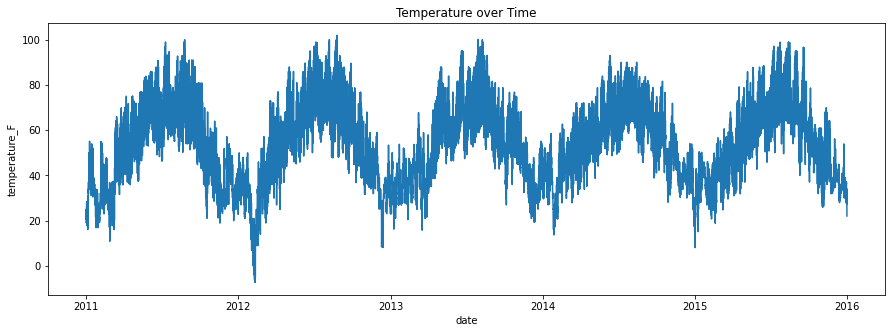

In [13]:
#Plot Temperature over time ('date')
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='temperature_F', data=weather)
plt.title('Temperature over Time')
plt.show()

In [20]:
#Create degree sign
degree_sign = u'\N{DEGREE SIGN}'
print(degree_sign)

°


In [22]:
#Visualize Winter Versus Summer by splitting into percentiles
winter_design_temp = np.percentile(weather['temperature_F'], 1)
summer_design_temp = np.percentile(weather['temperature_F'], 99)

#insert degree sign
print(f'Winter design temp: {winter_design_temp:.0f}{degree_sign} F \nSummer design temp: {summer_design_temp:.0f}{degree_sign} F')


Winter design temp: 18° F 
Summer design temp: 93° F


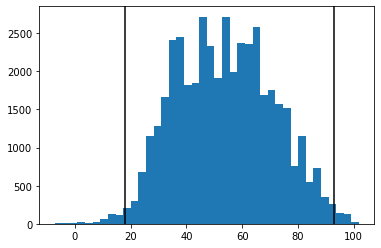

In [18]:
#Plot winter and summer design temperatures from the 1st and 99th percentiles of the temperature histogram. 
plt.hist(weather['temperature_F'], bins=40)
plt.axvline(winter_design_temp, c='k')
plt.axvline(summer_design_temp, c='k')
plt.show()

Analysis: 
The split between 1st and 99th percentiles will allow the contractor to appropriately size the heating and cooling systems. We are using 2011-2015 data for this, so the extremes of any specific year have less of an affect on my results. However, there might be overall trends in temperature that change over time - that could possibly affect our results. Let's compare the average temperatures between our beginning and ending years and see if there's a significant difference.

In [23]:
#Split data into 2 time periods: beginning, 2011 and end, 2015 timestamps
weather_2011 = weather.loc[weather['date'] <= '2011-12-31']
weather_2015 = weather.loc[(weather['date'] >= '2015-01-01') & (weather['date'] <= '2015-12-31')]

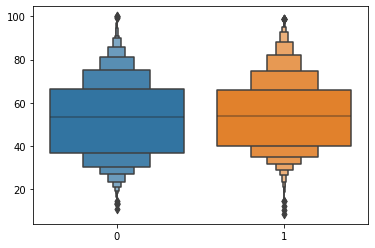

In [24]:
#Visualize
sns.boxenplot(data=[weather_2011['temperature_F'], weather_2015['temperature_F']])
plt.show()

In [25]:
#Run a t-test to see if signficant difference due to randomness
stats.ttest_ind(weather_2011['temperature_F'], weather_2015['temperature_F'])

Ttest_indResult(statistic=-5.449802489911195, pvalue=5.110836582308576e-08)

Our p-value is less than .001. Review Confidence Interval. 


In [26]:
#noted confidence upper and low bound
lower, upper = conf_int(weather_2015['temperature_F'], weather_2011['temperature_F'])
print(f'The difference in means at the 95% confidence level is between {lower:.2f} and {upper:.2f} degrees Farenheit.')

The difference in means at the 95% confidence level is between 0.93 and 1.97 degrees Farenheit.


Accordingly,with a p value of much smaller than 0.05, the difference in means is statistically significant. 

The actual difference in means is not very large. See how 2015 is between 1 and 2 degrees F hotter than 2011? This shouldn't make a huge difference in our estimates for winter and summer design temperatures.

*Issue 2: Should we consider a small wind energy turbine for power? (If average annual wind speed is below 5 meters per second, it's generally not a good investment.)*

Null Hypothesis: There is no difference between the mean wind speed and the required wind speed of 5.0 meters per second.

In [27]:
#Calculate average wind speed in meters per second
avg_mps = weather['windspeed_mps'].mean()
print(f'Annual average wind speed {avg_mps:.2f} meters per second')
print(f'Target annual average wind speed 5.0 meters per second')


Annual average wind speed 2.97 meters per second
Target annual average wind speed 5.0 meters per second


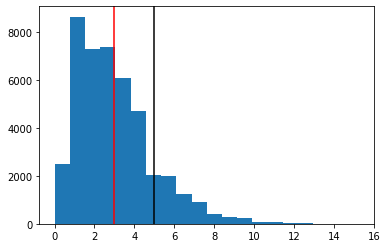

In [28]:
#Plot
plt.hist(weather['windspeed_mps'], bins=20)
plt.axvline(avg_mps, c='r')
plt.axvline(5.0, c='k')
plt.show()

Run a t-test to review if significant difference compared to 5 mps.

In [29]:
stats.ttest_1samp(weather['windspeed_mps'], 5.0)

Ttest_1sampResult(statistic=-220.75543592600232, pvalue=0.0)

In [31]:
#Using our established CI att 95%, check upper and lower
lower, upper = conf_int_1samp(weather['windspeed_mps'])
print(f'The population mean at the 95% confidence level is between {lower:.2f} and {upper:.2f} meters per second.')

The population mean at the 95% confidence level is between 2.95 and 2.98 meters per second.


Response
*   The average annual wind speed in the area is far too low (2.95 to 2.98 mps) for a wind power system. 

*   The p value for the 1 sample t test is so low it registers as 0.
*   Therefre, we should reject the null of no difference between the mean and the required wind speed of 5.0 meters per second. The population mean wind speed is only about 2.95 to 2.98 mps.

